In [1]:
from datasets import load_dataset
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


# KNN (K-Nearest Neighbours) Approach

We decided to experiment with a KNN model, predicting for a given pixel whether or not it belongs to a building

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)


image_train_dataset = load_dataset(
'keremberke/satellite-building-segmentation',
split='train', name='mini'
).to_pandas()
image_test_dataset = load_dataset(
'keremberke/satellite-building-segmentation',
split='test', name='mini'
).to_pandas()
image_train_dataset.head()

,image_id,image,width,height,objects
0,1217,"{'bytes': None, 'path': '/home/mic/.cache/hugg...",500,500,"{'id': [16678, 16679, 16680, 16681, 16682, 166..."
1,1517,"{'bytes': None, 'path': '/home/mic/.cache/hugg...",500,500,"{'id': [20602, 20603, 20604, 20605, 20606], 'a..."
2,1030,"{'bytes': None, 'path': '/home/mic/.cache/hugg...",500,500,"{'id': [14034, 14035, 14036, 14037, 14038, 140..."


In [3]:
print(image_train_dataset.size, image_test_dataset.size)

15 15


In [4]:
# Classes needed for processing data (personal dataSet class for Torch)

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        im = self.dataframe.iloc[index]
        image_path = im['image']['path']
        img = Image.open(image_path).convert('RGB')


        segmentation = self.parse_segmentation(im['objects'], img.size)
        #print(segmentation)
        # Transforms segmentation from numpy array to PIL image
        pil_segmentation = Image.fromarray(segmentation)
        if self.transform is not None:
            real_img = self.transform(img)
            real_segmentation = self.transform(pil_segmentation)

        #print(im['image'])
        # with index = 1 return the path of the first image of dataset

        #print(im['objects'])
        # Full dataframe, not sure what to use it for right now (contains id_objects [building or not, etc...])
        # See next markdown cell to see typical representation
        return {'image' : real_img, 'segmentation': real_segmentation }
    

    def parse_segmentation(self, object, size):
        
        segmentation_mask = np.zeros(size, dtype=np.uint8)

        for obj in object['segmentation']:
            for polygon in obj:
                polygon = np.array(polygon, dtype=np.int32)
                polygon = polygon.reshape((-1, 2))
                cv2.fillPoly(segmentation_mask, [polygon], 1)

        return segmentation_mask

In [5]:
# Setting up the dataframe
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((500, 500)),
    torchvision.transforms.ToTensor(),
])

train_df = MyDataset(image_train_dataset, transform)
test_df = MyDataset(image_test_dataset, transform)


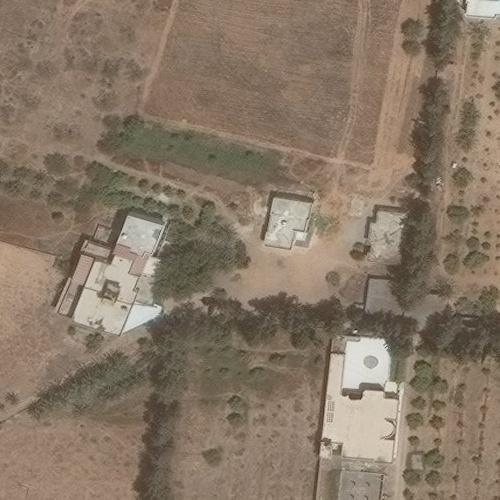

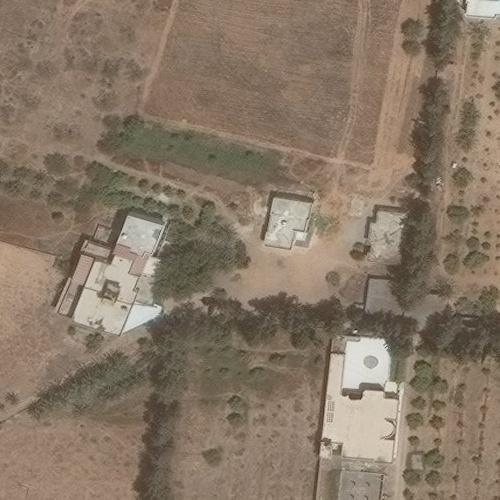

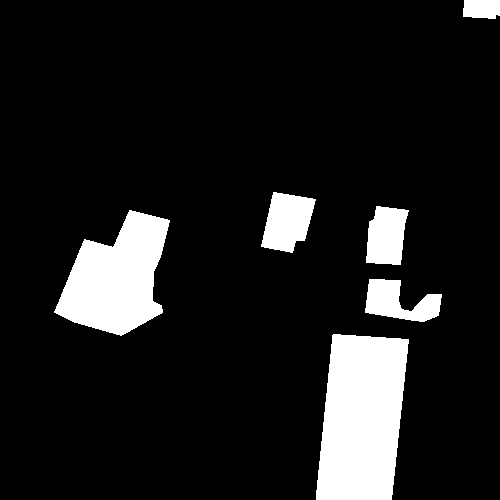

{'image': tensor([[[0.3647, 0.3608, 0.2902,  ..., 0.3412, 0.3490, 0.3373],
          [0.3294, 0.3059, 0.2863,  ..., 0.3529, 0.3608, 0.3451],
          [0.3333, 0.2824, 0.3059,  ..., 0.3569, 0.3647, 0.3529],
          ...,
          [0.2588, 0.2078, 0.2039,  ..., 0.6353, 0.6471, 0.6510],
          [0.2431, 0.2353, 0.2706,  ..., 0.4588, 0.5020, 0.5255],
          [0.2745, 0.2902, 0.3333,  ..., 0.3176, 0.3412, 0.3333]],
 
         [[0.3647, 0.3608, 0.2902,  ..., 0.2980, 0.3059, 0.2941],
          [0.3294, 0.3059, 0.2863,  ..., 0.3098, 0.3176, 0.3020],
          [0.3333, 0.2824, 0.3059,  ..., 0.3137, 0.3216, 0.3098],
          ...,
          [0.2431, 0.1922, 0.1882,  ..., 0.5882, 0.6000, 0.6039],
          [0.2275, 0.2196, 0.2549,  ..., 0.4118, 0.4549, 0.4784],
          [0.2588, 0.2745, 0.3176,  ..., 0.2706, 0.2941, 0.2863]],
 
         [[0.3255, 0.3216, 0.2510,  ..., 0.2824, 0.2902, 0.2784],
          [0.2902, 0.2667, 0.2471,  ..., 0.2941, 0.3020, 0.2863],
          [0.2941, 0.2431, 0.26

In [7]:
#Quick visualization of the data
display(torchvision.transforms.ToPILImage()(train_df[0]['image']).convert('RGB'))
display(torchvision.transforms.ToPILImage()(test_df[0]['image']).convert("RGB"))
display(torchvision.transforms.ToPILImage()(test_df[0]['segmentation']*255).convert("RGB"))
train_df[1]

## The input of the KnN model isn't actually an image, but a single pixel. So we need to process the data a little again

In [8]:
print(train_df[1]['image'])
print(test_df[1]['segmentation'])
X_pixels_train = []
Y_pixels_train = []
def get_list_pixels(dataset):
    X = []
    Y = []
    for image in dataset:
        for i in range(image['image'].shape[1]):
            for j in range(image['image'].shape[2]):
                X.append([float(image['image'][k][i][j])*255 for k in range(3)])
                Y.append(1 if float(image['segmentation'][0][i][j]) > 0 else 0)
    return np.array(X),np.array(Y)

X_pixels_train, Y_pixels_train = get_list_pixels(train_df)
X_pixels_test, Y_pixels_test = get_list_pixels(test_df)


tensor([[[0.3647, 0.3608, 0.2902,  ..., 0.3412, 0.3490, 0.3373],
         [0.3294, 0.3059, 0.2863,  ..., 0.3529, 0.3608, 0.3451],
         [0.3333, 0.2824, 0.3059,  ..., 0.3569, 0.3647, 0.3529],
         ...,
         [0.2588, 0.2078, 0.2039,  ..., 0.6353, 0.6471, 0.6510],
         [0.2431, 0.2353, 0.2706,  ..., 0.4588, 0.5020, 0.5255],
         [0.2745, 0.2902, 0.3333,  ..., 0.3176, 0.3412, 0.3333]],

        [[0.3647, 0.3608, 0.2902,  ..., 0.2980, 0.3059, 0.2941],
         [0.3294, 0.3059, 0.2863,  ..., 0.3098, 0.3176, 0.3020],
         [0.3333, 0.2824, 0.3059,  ..., 0.3137, 0.3216, 0.3098],
         ...,
         [0.2431, 0.1922, 0.1882,  ..., 0.5882, 0.6000, 0.6039],
         [0.2275, 0.2196, 0.2549,  ..., 0.4118, 0.4549, 0.4784],
         [0.2588, 0.2745, 0.3176,  ..., 0.2706, 0.2941, 0.2863]],

        [[0.3255, 0.3216, 0.2510,  ..., 0.2824, 0.2902, 0.2784],
         [0.2902, 0.2667, 0.2471,  ..., 0.2941, 0.3020, 0.2863],
         [0.2941, 0.2431, 0.2667,  ..., 0.2980, 0.3059, 0.

In [9]:
len(train_df)
print(X_pixels_train.shape)

(750000, 3)


In [10]:
from sklearn.model_selection import train_test_split
# create the 2 subsets, one for the training data, one for the testing to estimate the real accuracy of the model
Xtrain, Xtest, ytrain, ytest = train_test_split(X_pixels_train,Y_pixels_train,test_size=0.25, random_state=42) 
print(Xtrain[1], ytrain[1])
print(Xtest[1], ytest[1])
print("Number of data:", Y_pixels_train.shape)
print("Size of train:", ytrain.shape)
print("Size of test:", ytest.shape)

[184.00000423 182.00000435 169.00000513] 1
[118.00000057 106.00000128  90.00000224] 1
Number of data: (750000,)
Size of train: (562500,)
Size of test: (187500,)


In [22]:
import sklearn.neighbors as nn
#Here with 5 neighbours
clf = nn.KNeighborsClassifier(5)
clf.fit(Xtrain, ytrain)

KNeighborsClassifier()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


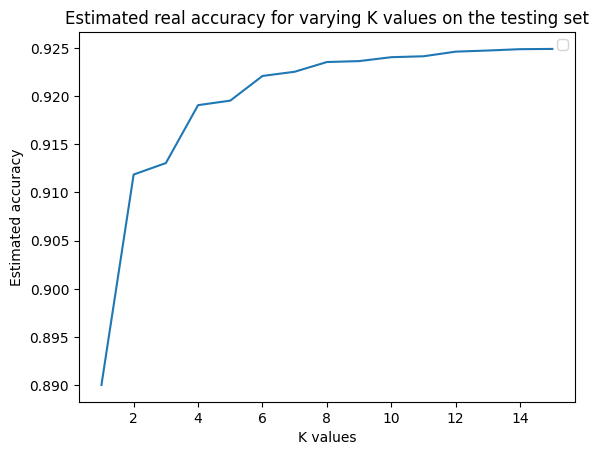

In [20]:
accuracies = []
for i in range(1,16):
    clf = nn.KNeighborsClassifier(i)
    clf.fit(Xtrain, ytrain)
    accuracies.append(clf.score(Xtest, ytest))
    
import matplotlib.pyplot as plt
plt.plot([i for i in range(1,16)], accuracies)
plt.xlabel("K values")
plt.ylabel("Estimated accuracy")
plt.title("Estimated real accuracy for varying K values on the testing set")
plt.legend()
plt.show()

In [15]:
def show_one_image(image,model):
    """Given an image in the input, display the image, the result of KNN and the segmented expected result"""
    print("Original Image :")
    display(torchvision.transforms.ToPILImage()(image['image']).convert('RGB'))
    print("Segmented Image using KNN :")
    image_to_display = np.zeros((1,500,500))
    print(image_to_display.shape)
    for i in range(image['image'].shape[1]):
        for j in range(image['image'].shape[2]):
            image_to_display[0][i][j] = torch.tensor(model.predict([[image['image'][k][i][j]*255 for k in range(3)]])[0])
    image_to_display = torch.tensor(image_to_display)
    display(torchvision.transforms.ToPILImage()(image_to_display).convert('RGB'))
    print("'True Segmentation' of the Image :")
    display(torchvision.transforms.ToPILImage()(image['segmentation']*255).convert('RGB'))

In [16]:
print(train_df[0]['segmentation'].shape)

torch.Size([1, 500, 500])


Original Image :


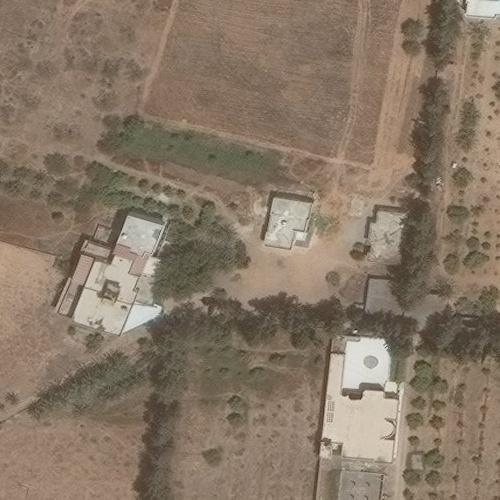

Segmented Image using KNN :
(1, 500, 500)


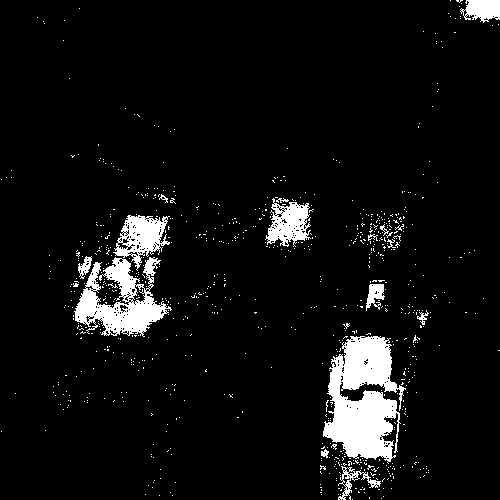

'True Segmentation' of the Image :


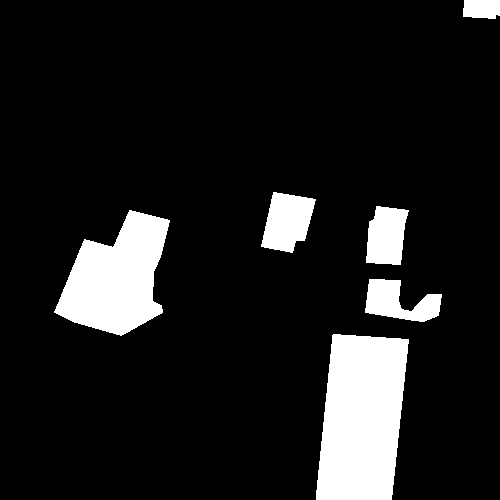

Original Image :


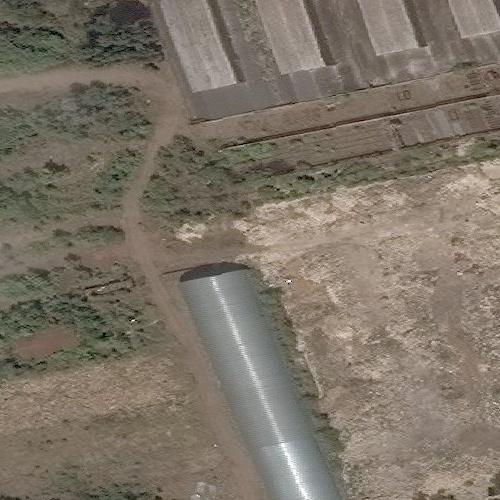

Segmented Image using KNN :
(1, 500, 500)


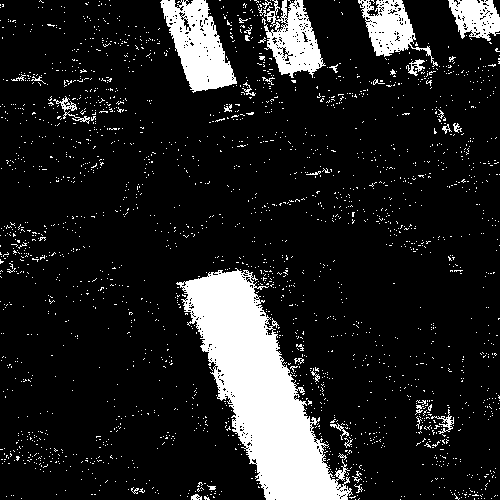

'True Segmentation' of the Image :


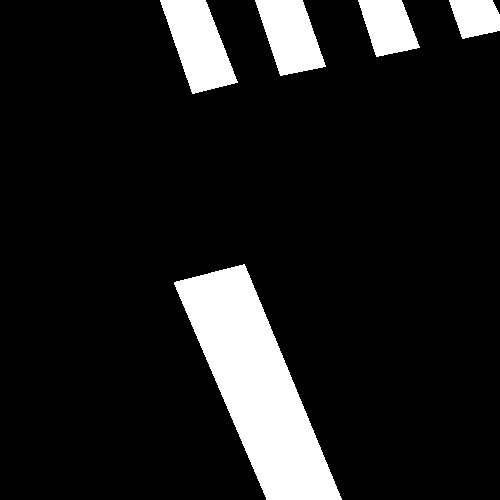

Original Image :


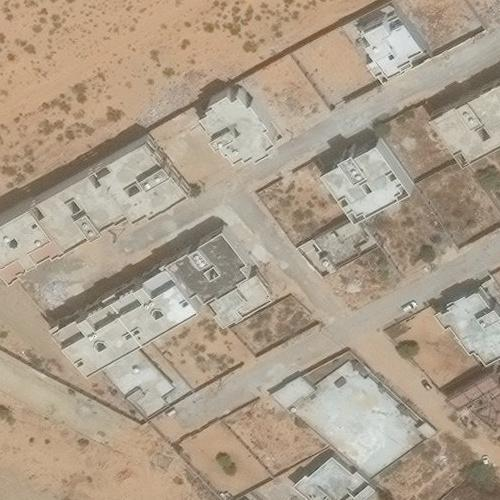

Segmented Image using KNN :
(1, 500, 500)


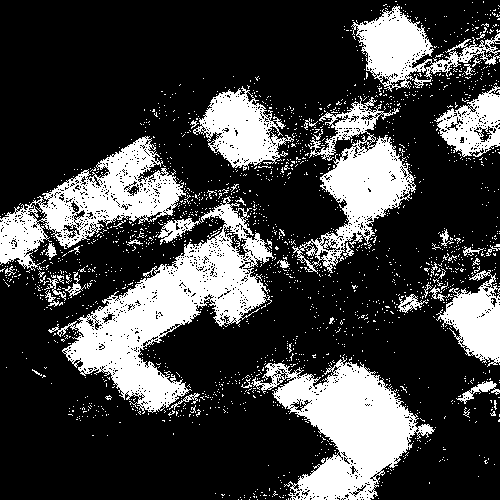

'True Segmentation' of the Image :


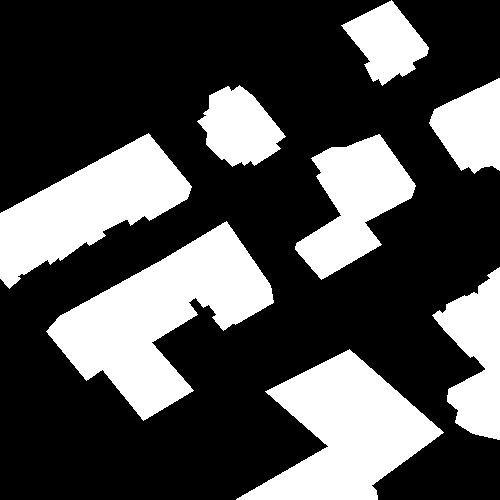

In [23]:
for i in range(3):
    show_one_image(train_df[i],clf)

Original Image :


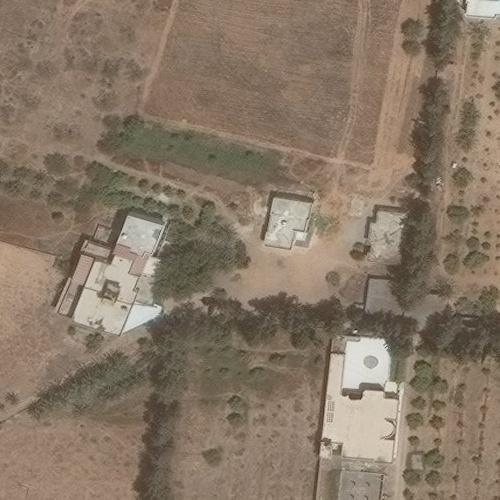

Segmented Image using KNN :
(1, 500, 500)


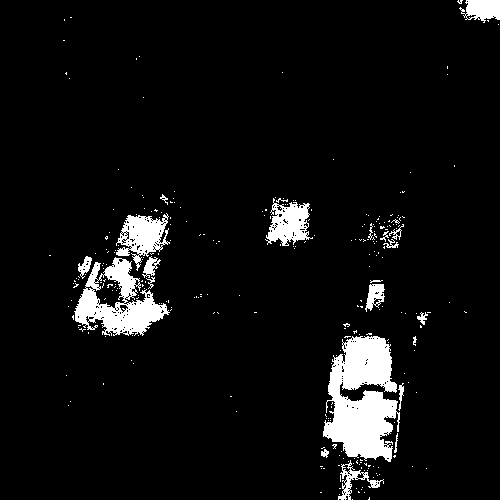

'True Segmentation' of the Image :


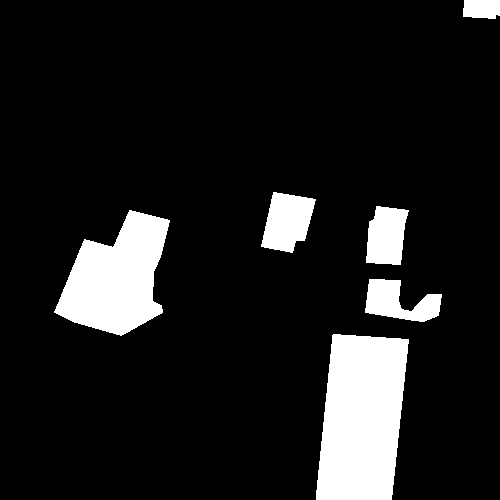

Original Image :


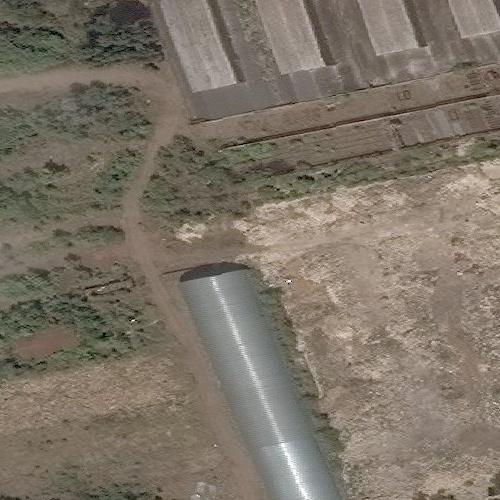

Segmented Image using KNN :
(1, 500, 500)


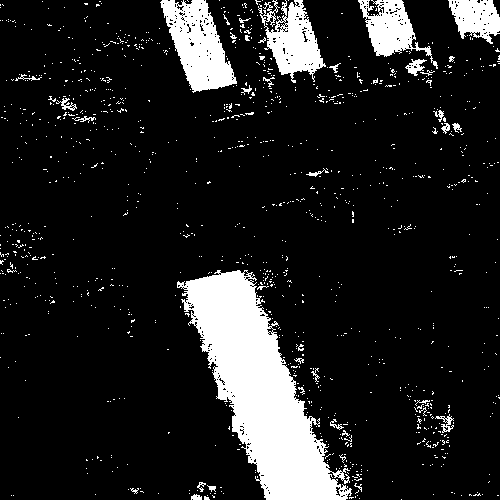

'True Segmentation' of the Image :


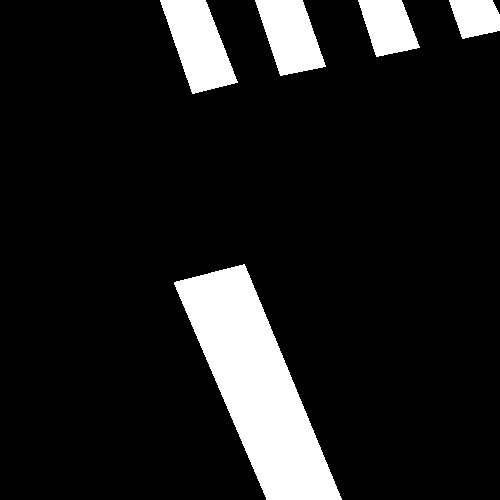

Original Image :


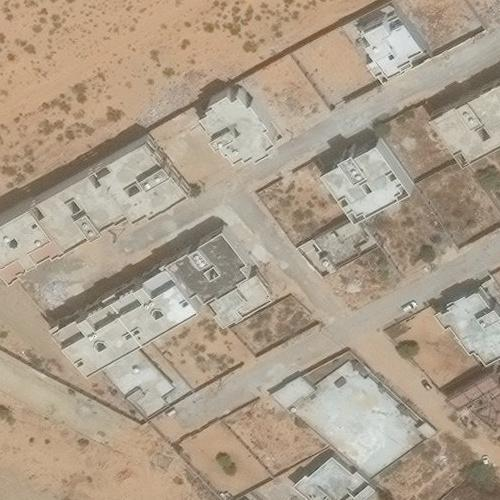

Segmented Image using KNN :
(1, 500, 500)


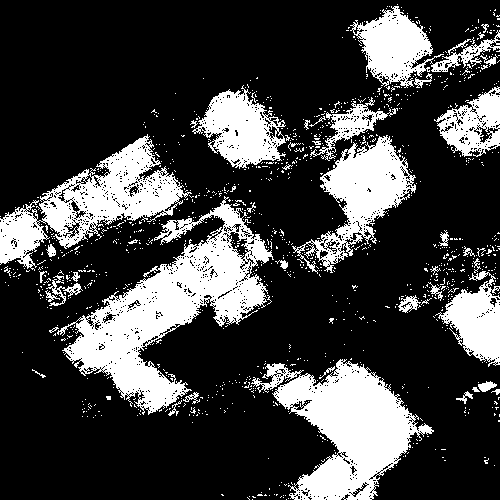

'True Segmentation' of the Image :


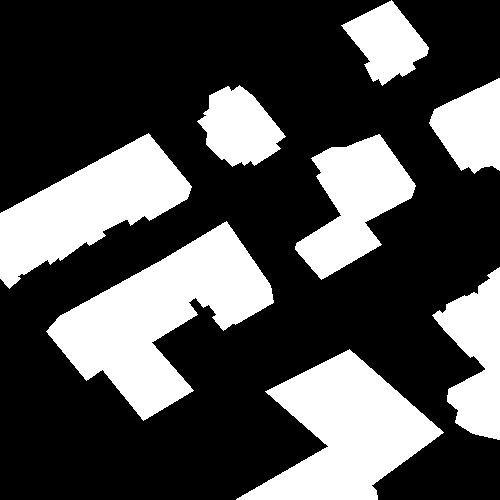

In [18]:
#Quick look with testing data (not used for training nor for evaluating accuracy (except with the mini dataset)
for i in range(3):
    show_one_image(train_df[i],clf)